# ApRES dat files --> zarr in a google bucket

This notebook uses xapres to load each dat file in a given directory and writes it to an individual zarr store in the ldeo-glaciology google bucket. It then writes lazily loads all the zarrs, concatenates them, and writes them to a single zarr store.

In [2]:
import numpy as np
import os
import gcsfs
import fsspec
import json
import xarray as xr
import sys
sys.path.append("/home/jovyan/XApRES/src/XApRES/")
import ApRESDefs
import zarr
from tqdm.notebook import trange, tqdm

## A101
There are three instruments in this datast, A101, A103, and A104. 

We start with A101.

### Get a list of the .DAT files in the A101 directory.

In [51]:
xa = ApRESDefs.xapres(max_range=1400)
dat_file_list = xa.list_files(directory='gs://ldeo-glaciology/GL_apres_2022/A101', 
            remote_load = True)

Load a token which enables us to write to the bucket.

In [4]:
with open('../../secrets/ldeo-glaciology-bc97b12df06b.json') as token_file:
    token = json.load(token_file)

Loop over the .DAT files in `dat_file_list` and loadthe data into an xarray using `ApRESDefs.xapres.load_all`

In [5]:
#dat_file_list  = dat_file_list[0:2]
directory='gs://ldeo-glaciology/GL_apres_2022/A101'

for file in tqdm(dat_file_list): 
    xa = ApRESDefs.xapres(max_range=1400)
    xa.load_all(directory, 
            remote_load = True,
            file_names_to_process=[file])
    filename = f'gs://ldeo-glaciology/GL_apres_2022_individual_zarrs_all_4/dat_{file}' 
    mapper = fsspec.get_mapper(filename, mode='w', token=token)
    
    #ds = xa.data
    #ds.attrs = []
    #ds.to_zarr(mapper, consolidated=False)

  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
dat_file_list[0:2]

['ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-22-1939/DATA2022-05-22-1939.DAT',
 'ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-26-1530/DATA2022-05-26-1530.DAT']

Start a cluster (first use the menu on the left to create this cell).

In [8]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:45273")
client

<Client: 'tcp://127.0.0.1:45273' processes=20 threads=40, memory=146.95 GiB>

Load and concatenate all the A101 zarr files. 

In [9]:
ds_all = xr.open_mfdataset("gs://ldeo-glaciology/GL_apres_2022_individual_zarrs_all_4/dat*",
                           chunks = {}, 
                           engine = 'zarr', 
                           consolidated = False, 
                           parallel = True)
ds_all

<xarray.Dataset>
Dimensions:          (time: 11723, attenuator_setting_pair: 2,
                      chirp_time: 40001, chirp_num: 20, profile_range: 6658)
Coordinates:
    AFGain           (time, attenuator_setting_pair) int64 dask.array<chunksize=(13, 2), meta=np.ndarray>
    attenuator       (time, attenuator_setting_pair) float64 dask.array<chunksize=(13, 2), meta=np.ndarray>
    burst_number     (time) int64 dask.array<chunksize=(13,), meta=np.ndarray>
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
  * chirp_time       (chirp_time) timedelta64[ns] 00:00:00 ... 00:00:01
    filename         (time) <U83 dask.array<chunksize=(13,), meta=np.ndarray>
  * profile_range    (profile_range) float64 0.0 0.2103 ... 1.4e+03 1.4e+03
  * time             (time) datetime64[ns] 2022-05-22T19:40:20 ... 2022-09-25...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 dask.array<chunksize=(13,), meta=np.ndarray>
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 dask.array<chunksize=(4, 5001, 5, 1), meta=np.ndarray>
    latitude         (time) float64 dask.array<chunksize=(13,), meta=np.ndarray>
    longitude        (time) float64 dask.array<chunksize=(13,), meta=np.ndarray>
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 dask.array<chunksize=(4, 1665, 5, 1), meta=np.ndarray>
    temperature_1    (time) float64 dask.array<chunksize=(13,), meta=np.ndarray>
    temperature_2    (time) float64 dask.array<chunksize=(13,), meta=np.ndarray>

Check how large the dataset is

In [10]:
ds_all.nbytes/1e9

200.016558212

Check the first and last filename. 

They file should be (from looking at the google bucket directly):
- DATA2022-05-22-1939.DAT 
- DATA2022-09-24-2120.DAT
 

In [36]:
ds_all.time.shape[0]

11723

In [18]:
print(f"first file name in dataset: {ds_all.filename[0].values}")
print(f"last file name in dataset: {ds_all.filename[-1].values}")

first file name in dataset: ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-22-1939/DATA2022-05-22-1939.DAT
last file name in dataset: ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-09-22-2220/DATA2022-09-24-2120.DAT


Check that there are roughly the correct number of time slices.

In [37]:
fs = gcsfs.GCSFileSystem()
A101_dats_in_bucket = fs.glob(directory + '/**/*.DAT', recursive = True)
number_of_A101_dats_in_bucket = len(A101_dats_in_bucket)
dat = xa.load_dat_file(A101_dats_in_bucket[30], remote_load= True)
number_of_bursts_dat_approx = dat.NoBurstsInFile

approx_number_of_times = number_of_bursts_dat_approx * number_of_A101_dats_in_bucket
print(f"The number of time slices should be approximately {approx_number_of_times}")
print(f"In fact it is {ds_all.time.shape[0]}")

The number of time slices should be approximately 11938
In fact it is 11723


Check that the time slices are all in order. First by plotting the values.

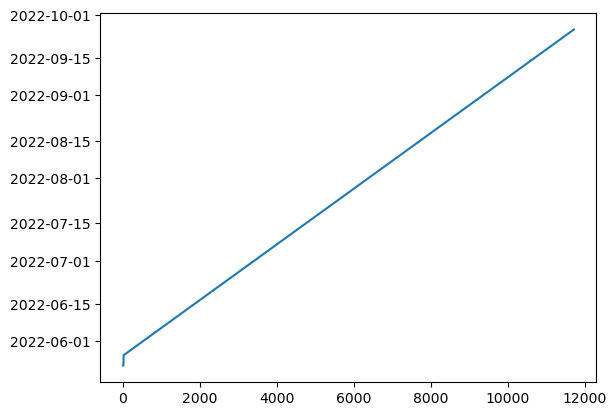

In [59]:
import matplotlib.pyplot as plt
plt.plot(ds_all.time.values)

Check that the time dimension is increasing by taking the diff. We see that the minimum diff value is postive, so `time` must be increasing. 

In [57]:
assert ds_all.time.diff(dim='time').min() > 0 

Check that all the dat files are in the dataset

In [58]:
# take the filenames from the dataset
unique_filenames = np.unique(ds_all.filename.values) 
# and ccheck that they are the same as the files loaded by xapres in the call at the top of this NB
assert all(unique_filenames == dat_file_list)

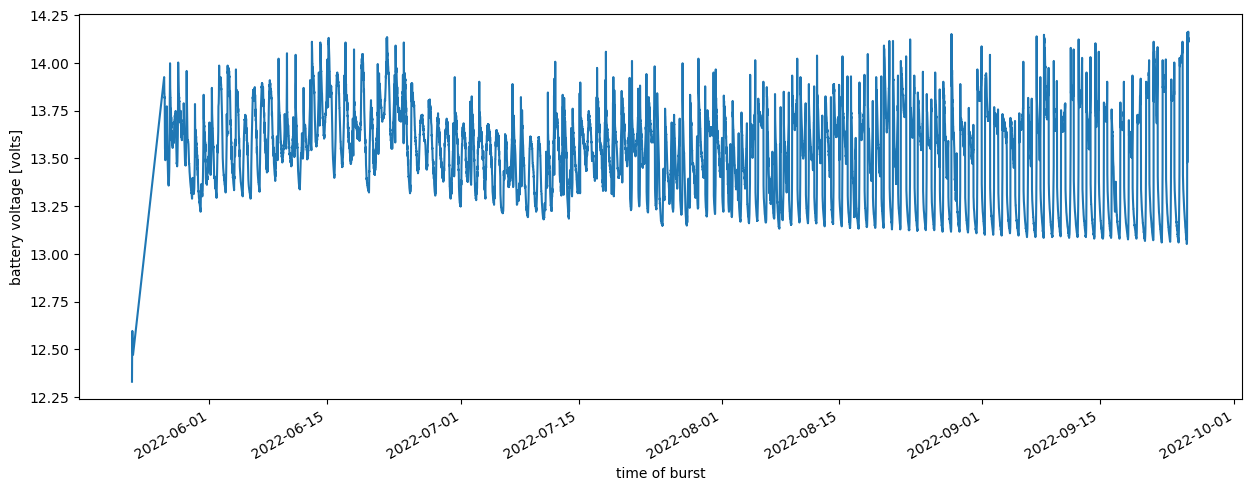